In [335]:
import numpy as np
import pandas as pd

Bayes Theorem States that:

$$
P(Y|X) = \frac{P(Y \cap X)}{P(X)} = \frac{P(Y) * P(X|Y)}{P(X)}$$

Therefore, if we get enough observations of X, we can surmise Y using Bayes

In [336]:
golf = pd.read_excel("../Class_Data/golf_categories.xlsx")

In [337]:
golf.head()

,Temperature,Humidity,Outlook,Wind,Play
0,High,Medium,Sunny,False,No
1,High,High,Sunny,True,No
2,Low,Low,Rain,True,No
3,Medium,High,Sunny,False,No
4,Low,Medium,Rain,True,No


In [338]:
play_yes = len(golf[golf['Play'] == "Yes"])
play_no = len(golf[golf['Play'] == "No"])

In [339]:
features_dfs = {}
features = ['Temperature', 'Humidity', 'Outlook', 'Wind']
laplace = True

for feature in features:
    df = golf.groupby(['Play', feature], as_index=False).count().iloc[:, :3]
    df['Occurrences'] = df.apply(
    lambda x: x.iloc[2]/play_yes if x['Play'] == 'Yes' else x.iloc[2]/play_no,
    axis=1
)
    df.drop(df.columns[2], axis=1)
    features_dfs[feature] = df.pivot(index=df.columns[1], columns='Play', values='Occurrences').reset_index()

if laplace == True:
    for name, df in features_dfs.items():
        df.fillna({'Yes': 1/play_yes}, inplace=True)
        df.fillna({'No': 1/play_no}, inplace=True)

In [340]:
# All the bayes theorems probabilities
for name, df in features_dfs.items():
    print(name)
    print(df, "\n")

Temperature
Play Temperature   No       Yes
0           High  0.4  0.222222
1            Low  0.4  0.444444
2         Medium  0.2  0.333333 

Humidity
Play Humidity   No       Yes
0        High  0.4  0.222222
1         Low  0.2  0.444444
2      Medium  0.4  0.333333 

Outlook
Play   Outlook   No       Yes
0     Overcast  0.2  0.444444
1         Rain  0.4  0.333333
2        Sunny  0.6  0.222222 

Wind
Play   Wind   No       Yes
0     False  0.4  0.666667
1      True  0.6  0.333333 



In [341]:
record = {
    'Temperature': 'High',
    'Humidity': 'Low',
    'Outlook': 'Overcast',
    'Wind': False
}

In [342]:
yes = play_yes / (play_yes + play_no)
no = play_no / (play_yes + play_no)

for name, feature in features_dfs.items():
    yes *= feature[feature[name] == record[name]]['Yes'].iloc[0]
    no *= feature[feature[name] == record[name]]['No'].iloc[0]

# Now calculate the probability of playing and not playing via normalization
p_yes = yes / (yes + no)
p_no = no / (yes + no)

if p_yes >= 0.5:
    print('Play')
else:
    print("Don't play")
p_yes, p_no

Play


(np.float64(0.8916629514043691), np.float64(0.1083370485956309))

For Numerical Attributes, numbers should be normalized using the normal distribution

## Sci-Kit Learn

Naive Bayes is a classifier that relies on the assumption that every feature is independent from itself, and therefore, Bayes Theorem can apply to an unknown by discovering probabilities from the training data.
<br><br>
This makes Bayes Theorem a strong and fast classifier for simpler models, such as computer vision. However, Naive Bayes is a bad estimator, so the propensity score from its predictions is usually ignored. 

The Simple way to use categorical variables in GuassianNB, using pd.get_dummies
<br>You need to drop the rows, and then rejoin them
<br>Either using np.concat or pd.concat the dataframes

In [411]:
# Gaussian Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

golf_numerical = pd.read_csv('../Class_Data/golf.csv')

# Nominal to Binominal (yes = 1 no = 0)
golf_numerical['Play'] = golf_numerical['Play'].map(
    {'yes': 1, 'no': 0}
)

# Create dummy variables
golf_dummies = pd.get_dummies(golf_numerical[['Outlook']])

golf_concat = pd.concat([golf_numerical, golf_dummies], axis=1)
golf_concat.drop(['Outlook'], axis=1, inplace=True)

X = golf_concat.drop('Play', axis=1).values
y = golf_concat['Play'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

gnb = GaussianNB()

gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

from sklearn.metrics import classification_report
print("Classification report")
print(classification_report(y_test, y_pred))

Classification report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.50      0.67         4

    accuracy                           0.67         6
   macro avg       0.75      0.75      0.67         6
weighted avg       0.83      0.67      0.67         6



In [412]:
gnb.score(X_test, y_test)

0.6666666666666666

The next way to do this is by using a pipeline and an encoder, this way, when you train your encoder, you use the same data split

The Pipeline allows for multiple processes to take place in call of the fit function, this prevents data leakage from the parametrization and the fitting of the model

Column Transformer allows us to perform seperate transformations inside a pipeline, for this naive bayes model, we will be normalizing the numerical data, and using one hot encoder on the categorical data

In [416]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split

golf = pd.read_csv('../Class_Data/golf.csv')
golf['Play'] = golf['Play'].map({'yes': 1, 'no': 0})

X = golf.drop('Play', axis=1)
y = golf['Play']

golf.info(), X, y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      14 non-null     object
 1   Temperature  14 non-null     int64 
 2   Humidity     14 non-null     int64 
 3   Windy        14 non-null     bool  
 4   Play         14 non-null     int64 
dtypes: bool(1), int64(3), object(1)
memory usage: 594.0+ bytes


(None,
      Outlook  Temperature  Humidity  Windy
 0      Sunny           85        85  False
 1      Sunny           80        90   True
 2   Overcast           83        78  False
 3       Rain           70        96  False
 4       Rain           68        80  False
 5       Rain           65        70   True
 6   Overcast           64        65   True
 7      Sunny           72        95  False
 8      Sunny           69        70  False
 9       Rain           75        80  False
 10     Sunny           75        70   True
 11  Overcast           72        90   True
 12  Overcast           81        75  False
 13      Rain           71        80   True,
 0     0
 1     0
 2     1
 3     1
 4     1
 5     0
 6     1
 7     0
 8     1
 9     1
 10    1
 11    1
 12    1
 13    0
 Name: Play, dtype: int64)

In [472]:

# Got a bug because the training data was missing the Overcast variable
# We will fix this by including all categories in the encoder
# This is good practice when the data is small and there are few categories
preprocessor = ColumnTransformer(
    [
        ('categories', OneHotEncoder(
            categories = [['Sunny', 'Overcast', 'Rain']],
            dtype='int'
            ), ['Outlook']),
    ],
    remainder ='passthrough',
    force_int_remainder_cols = False
)
preprocessor

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('categories',
                                 OneHotEncoder(categories=[['Sunny', 'Overcast',
                                                            'Rain']],
                                               dtype='int'),
                                 ['Outlook'])])

In [473]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('guassiannb', GaussianNB())
])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('categories',
                                                  OneHotEncoder(categories=[['Sunny',
                                                                             'Overcast',
                                                                             'Rain']],
                                                                dtype='int'),
                                                  ['Outlook'])])),
                ('guassiannb', GaussianNB())])

In [474]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=1992
)

clf = RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'guassiannb__var_smoothing': loguniform(1e-12, 1e-7)
    },
    scoring='accuracy',
    cv=4,
    n_jobs=-1,
    return_train_score=True,
    random_state=1992
)

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('categories',
                                                                               OneHotEncoder(categories=[['Sunny',
                                                                                                          'Overcast',
                                                                                                          'Rain']],
                                                                                             dtype='int'),
                                                                               ['Outlook'])])),
                                             ('guassiannb', GaussianNB())]),
                   n_jobs=-1,
                   param_distributions={'guassiannb__var_smoothing': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000015A3A0F4E90>},
                   random_state=1992, return_train_score=True,
                   scoring='accuracy')

In [475]:
# Our model is now too complex for this dataset
max(clf.cv_results_['mean_train_score'])

np.float64(0.7291666666666666)

In [476]:
y_pred = clf.predict(X_test)

Accuracy: 0.6666666666666666
Consuion Matrix:
 [[1 0]
 [1 1]]


<Figure size 700x700 with 0 Axes>

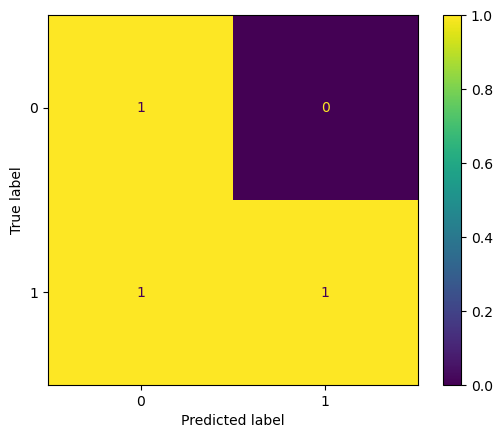

In [477]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay
)
import matplotlib.pyplot as plt


print("Accuracy:", accuracy_score(y_test, y_pred))

m = confusion_matrix(
        y_test, 
        y_pred, 
        labels=clf.classes_)

print("Consuion Matrix:\n", m)

plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(m, display_labels=clf.classes_)
disp.plot()
plt.show()

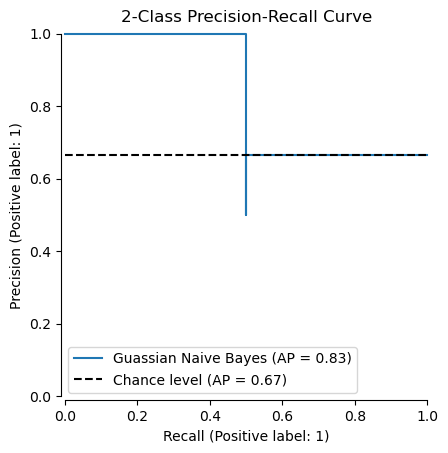

In [478]:
disp = PrecisionRecallDisplay.from_estimator(
    estimator=clf, 
    X=X_test, 
    y=y_test,
    name="Guassian Naive Bayes",
    plot_chance_level=True,
    despine=True
)

_ = disp.ax_.set_title("2-Class Precision-Recall Curve")

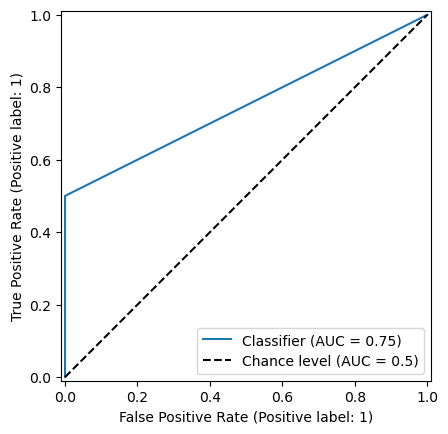

In [479]:
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level=True)

### Multinomial Naive Bayes<br>
Used for multinomially distributed data, mostly used for text classification.
<br>
A finite set of vectors theta_y = (theta_y_1, ..., theta_y_n) are used to parametrize the distribution of each class y, where n is the number of features, and y_i is the probability $P(X_i|y)$

The parameters $\theta_y$ is estimated by a smoothed version of max likelikehood: <br>

$$\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}$$

Where $N_{yi}$ = the sum of x_i for all x in your training set T, and N_y is the total count of all features for class y. <br>

The smoothing priors $\alpha \geq 0$ accounts for features not present in the learning samples. This is where your Laplace correction can take place:

Lapace: $\alpha = 1$, missing values are imputed by giving something with a $P(X|Y = \text{outcome}) = 0$ a probability of $ \frac{1}{|Y = \text{outcome}|}$

In [480]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split

golf = pd.read_csv('../Class_Data/golf.csv')
golf['Play'] = golf['Play'].map({'yes': 1, 'no': 0})

X = golf.drop('Play', axis=1)
y = golf['Play']

X, y

(     Outlook  Temperature  Humidity  Windy
 0      Sunny           85        85  False
 1      Sunny           80        90   True
 2   Overcast           83        78  False
 3       Rain           70        96  False
 4       Rain           68        80  False
 5       Rain           65        70   True
 6   Overcast           64        65   True
 7      Sunny           72        95  False
 8      Sunny           69        70  False
 9       Rain           75        80  False
 10     Sunny           75        70   True
 11  Overcast           72        90   True
 12  Overcast           81        75  False
 13      Rain           71        80   True,
 0     0
 1     0
 2     1
 3     1
 4     1
 5     0
 6     1
 7     0
 8     1
 9     1
 10    1
 11    1
 12    1
 13    0
 Name: Play, dtype: int64)

In [492]:
# Convert all numerical features to multinominal
preprocessor = ColumnTransformer(
    [
        ('discretizer', KBinsDiscretizer(
            encode='ordinal',
            n_bins=3,
            strategy='uniform'
        ), ['Temperature', 'Humidity']),
        ('hot_encoder', OneHotEncoder(
            categories=[['Sunny', 'Overcast', 'Rain']],
            dtype='int'
        ), ['Outlook'])
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('multinominalnb', MultinomialNB(alpha=1))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3333,
    random_state=1992
)

# search = GridSearchCV(
#     estimator=pipe,
#     param_grid={
#         'preprocessor__discretizer__strategy': ['uniform', 'quantile', 'kmeans']
#     },
#     scoring='accuracy',
#     cv=4,
#     n_jobs=-1,
#     return_train_score=True
# )

pipe.fit(X_train, y_train)

print("Training Score:", pipe.score(X_train, y_train))
# print("Best Params:", pipe.best_params_)

Training Score: 0.7777777777777778


Accuracy of Test: 0.6


<Figure size 600x600 with 0 Axes>

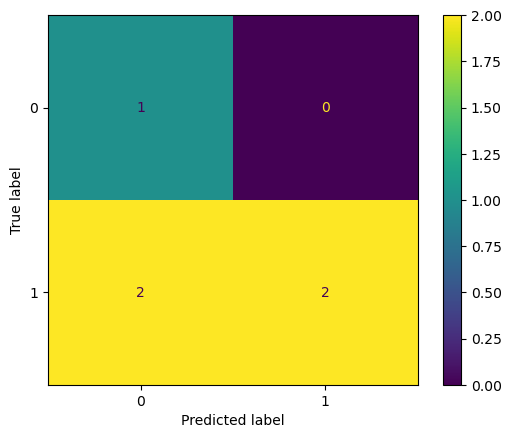

<Figure size 500x500 with 0 Axes>

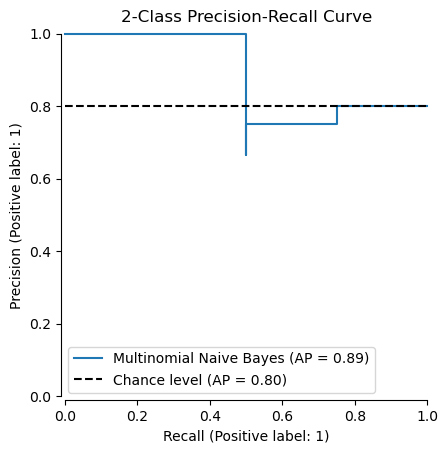

<Figure size 500x500 with 0 Axes>

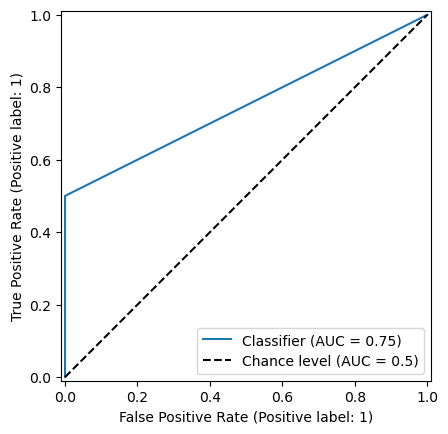

In [493]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay
)
import matplotlib.pyplot as pyplot

y_pred = pipe.predict(X_test)

print("Accuracy of Test:", accuracy_score(y_test, y_pred))

m = confusion_matrix(
    y_test,
    y_pred,
    labels=pipe.classes_
)

plt.figure(figsize=(6, 6))
cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=m,
    display_labels=pipe.classes_
)
cm_disp.plot()
plt.show()

plt.figure(figsize=(5, 5))
pr_disp = PrecisionRecallDisplay.from_estimator(
    estimator=pipe,
    X=X_test,
    y=y_test,
    name="Multinomial Naive Bayes",
    plot_chance_level=True,
    despine=True
)

_ = pr_disp.ax_.set_title("2-Class Precision-Recall Curve")
plt.show()

plt.figure(figsize=(5, 5))
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level=True)
plt.show()